# Import libs

In [1]:
# sklearn / numpy
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Lasso
import numpy as np

# implemented structure
from src.handleData import handleData
from src.handleClassifier import handleClassifier
from src.handleMetrics import handleMetrics

# Load data

In [2]:
hD = handleData("./data/data.csv")  # construct handleData object
df = hD.loadData("id")  # load the data
labels = hD.encodeLabels(df, "species")  # get labels
XTrain, YTrain, XTest, YTest = hD.splitData(
    df, 0.7, "species"
)  # get the training and testing sets/labels

# Training phase
## Setting the classifiers and their configuration

In [3]:
# The selected classifiers and their config
classifierList = [
    {
        "name": "LinearDiscriminantAnalysis",
        "preprocess": False,
        "fitStrategy": {
            "option": "CV",
            "config": {"n_jobs": -1, "scoring": "accuracy"},
        },
    },
    {
        "name": "QuadraticDiscriminantAnalysis",
        "preprocess": False,
        "fitStrategy": {
            "option": "CV",
            "config": {"n_jobs": -1, "scoring": "accuracy"},
        },
    },
    {
        "name": "LogisticRegression",
        "preprocess": True,
        "fitStrategy": {
            "option": "GridSearch",
            "config": {
                "param_grid": {
                    "clf__C": [0.01, 0.05, 0.1, 0.5, 1.0, 1.5, 2.0],
                },
                "n_jobs": -1,
                "scoring": "accuracy",
            },
        },
    },
    {
        "name": "SGDClassifier",
        "preprocess": True,
        "fitStrategy": {
            "option": "GridSearch",
            "config": {
                "param_grid": {
                    "clf__alpha": [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 2.0],
                },
                "n_jobs": -1,
                "scoring": "accuracy",
            },
        },
    },
    {
        "name": "DecisionTreeClassifier",
        "preprocess": False,
        "fitStrategy": {
            "option": "GridSearch",
            "config": {
                "param_grid": {
                    "clf__criterion": ["gini", "entropy"],
                    "clf__min_samples_leaf": list(range(1, 6)),
                    "clf__min_samples_split": list(range(2, 12, 2)),
                    "clf__max_depth": list(range(1, 11)),
                },
                "n_jobs": -1,
                "scoring": "accuracy",
            },
        },
    },
    {
        "name": "RandomForestClassifier",
        "preprocess": False,
        "fitStrategy": {
            "option": "GridSearch",
            "config": {
                "param_grid": {
                    "clf__min_samples_leaf": list(range(1, 6)),
                    "clf__min_samples_split": list(range(2, 12, 2)),
                    "clf__n_estimators": [50, 75, 100],
                    "clf__max_depth": list(range(1, 6)),
                },
                "n_jobs": -1,
                "scoring": "accuracy",
            },
        },
    },
    {
        "name": "AdaBoostClassifier",
        "preprocess": False,
        "config": {"base_estimator": DecisionTreeClassifier()},
        "fitStrategy": {
            "option": "GridSearch",
            "config": {
                "param_grid": {
                    "clf__base_estimator__max_depth": [1, 5, 10],
                    "clf__n_estimators": [50, 75, 100],
                    "clf__learning_rate": [0.01, 0.1, 1.0],
                },
                "n_jobs": -1,
                "scoring": "accuracy",
            },
        },
    },
    {
        "name": "BaggingClassifier",
        "preprocess": False,
        "config": {"base_estimator": DecisionTreeClassifier()},
        "fitStrategy": {
            "option": "GridSearch",
            "config": {
                "param_grid": {
                    "clf__base_estimator__max_depth": [1, 5, 10],
                    "clf__n_estimators": [50, 75, 100],
                    "clf__max_samples": [0.25, 0.5, 0.75, 1.0],
                    "clf__max_features": [0.25, 0.5, 0.75, 1.0],
                },
                "n_jobs": -1,
                "scoring": "accuracy",
            },
        },
    },
    {
        "name": "SVC",
        "preprocess": False,
        "fitStrategy": {
            "option": "GridSearch",
            "config": {
                "param_grid": [
                    {"clf__C": [1, 10, 100, 1000], "clf__kernel": ["linear"]},
                    {
                        "clf__C": [1, 10, 100, 1000],
                        "clf__kernel": ["poly"],
                        "clf__degree": list(range(2, 9)),
                        "clf__coef0": list(np.linspace(0.000001, 2, num=10)),
                    },
                    {
                        "clf__C": [1, 10, 100, 1000],
                        "clf__kernel": ["rbf"],
                        "clf__gamma": ["scale", "auto"],
                        "clf__gamma": list(np.linspace(0.000001, 2, num=10)),
                    },
                    {
                        "clf__C": [1, 10, 100, 1000],
                        "clf__kernel": ["sigmoid"],
                        "clf__coef0": list(np.linspace(0.000001, 2, num=10)),
                    },
                ],
                "n_jobs": -1,
                "scoring": "accuracy",
            },
        },
    },
    {
        "name": "LinearSVC",
        "preprocess": False,
        "config": {"dual": False},
        "fitStrategy": {
            "option": "GridSearch",
            "config": {
                "param_grid": {
                    "clf__C": np.logspace(-3, 3, 7),
                    "clf__multi_class": ["crammer_singer", "ovr"],
                    "clf__penalty": ["l1", "l2"],
                },
                "n_jobs": -1,
                "scoring": "accuracy",
            },
        },
    },
    {
        "name": "KNeighborsClassifier",
        "preprocess": False,
        "fitStrategy": {
            "option": "GridSearch",
            "config": {
                "param_grid": {"clf__n_neighbors": np.arange(2, 15)},
                "n_jobs": -1,
                "scoring": "accuracy",
            },
        },
    },
]

## No feature trimming

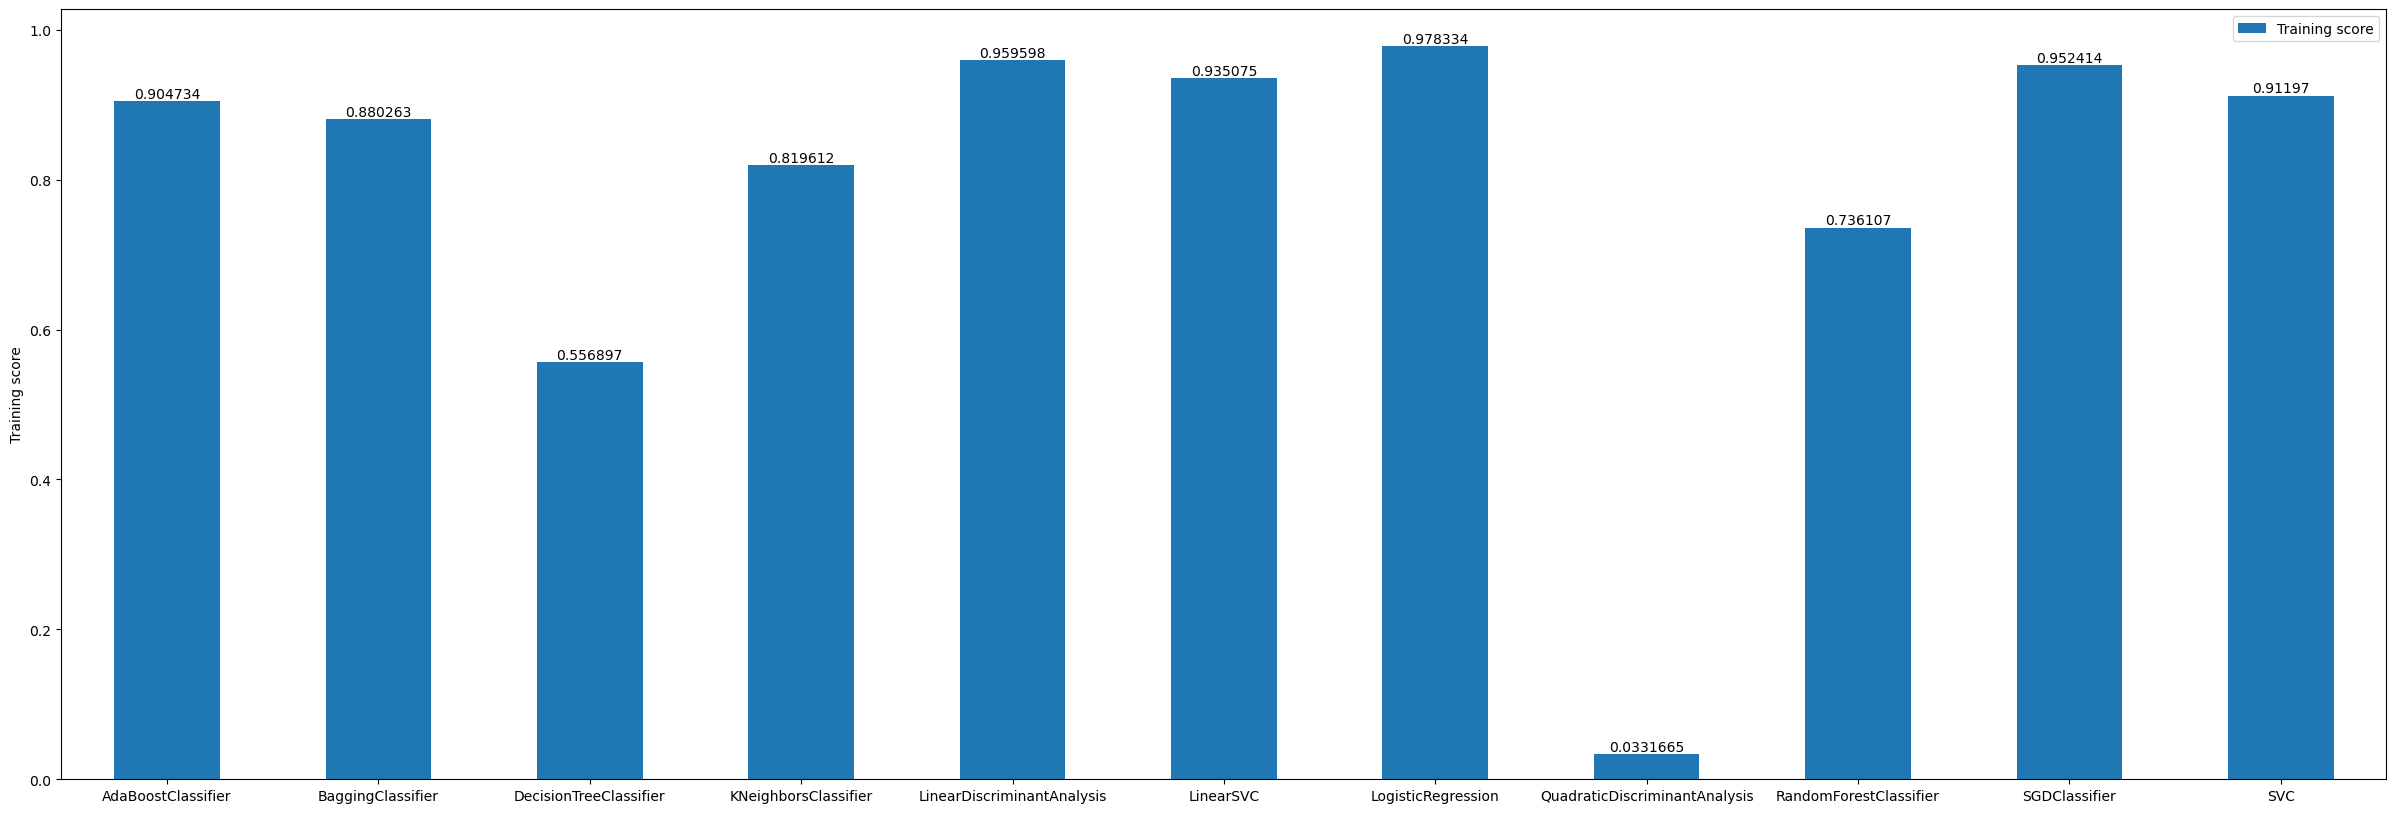

In [4]:
hC = handleClassifier()  # construct handleClassifier object
clf = hC.fitClassifiers(XTrain, YTrain, classifierList)  # fit

## Feature reduction (PCA)

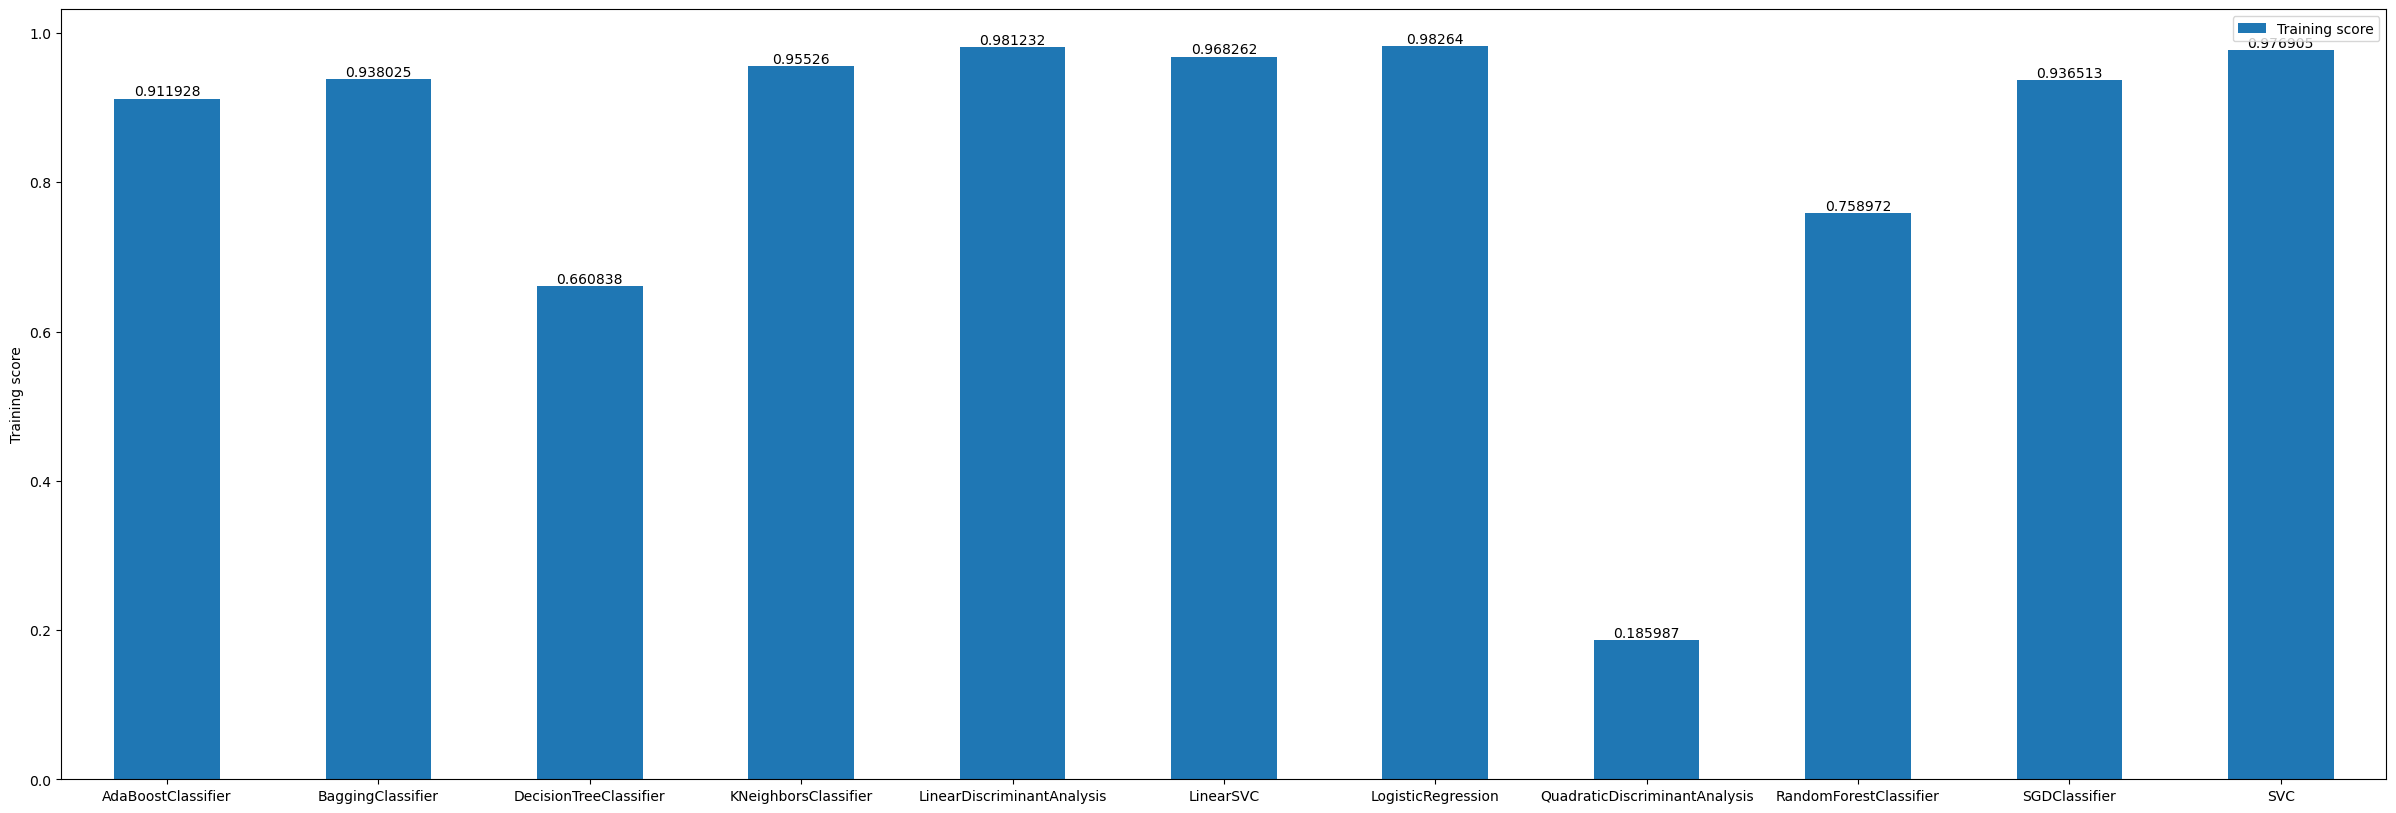

In [5]:
# change the config for a feature reduction
for classifierDict in classifierList:
    classifierDict["preprocess"] = True
    classifierDict["feature"] = {"option": "reduction"}
    classifierDict["fitStrategy"]["option"] = "GridSearch"

    if not "param_grid" in classifierDict["fitStrategy"]["config"]:
        classifierDict["fitStrategy"]["config"]["param_grid"] = dict()

    if isinstance(classifierDict["fitStrategy"]["config"]["param_grid"], list):
        for L in classifierDict["fitStrategy"]["config"]["param_grid"]:
            L["ftr__n_components"] = [
                0.5,
                0.75,
                0.85,
            ]

    else:
        classifierDict["fitStrategy"]["config"]["param_grid"]["ftr__n_components"] = [
            0.5,
            0.75,
            0.85,
        ]

clfReduction = hC.fitClassifiers(XTrain, YTrain, classifierList)  # fit

## Feature selection (Lasso)

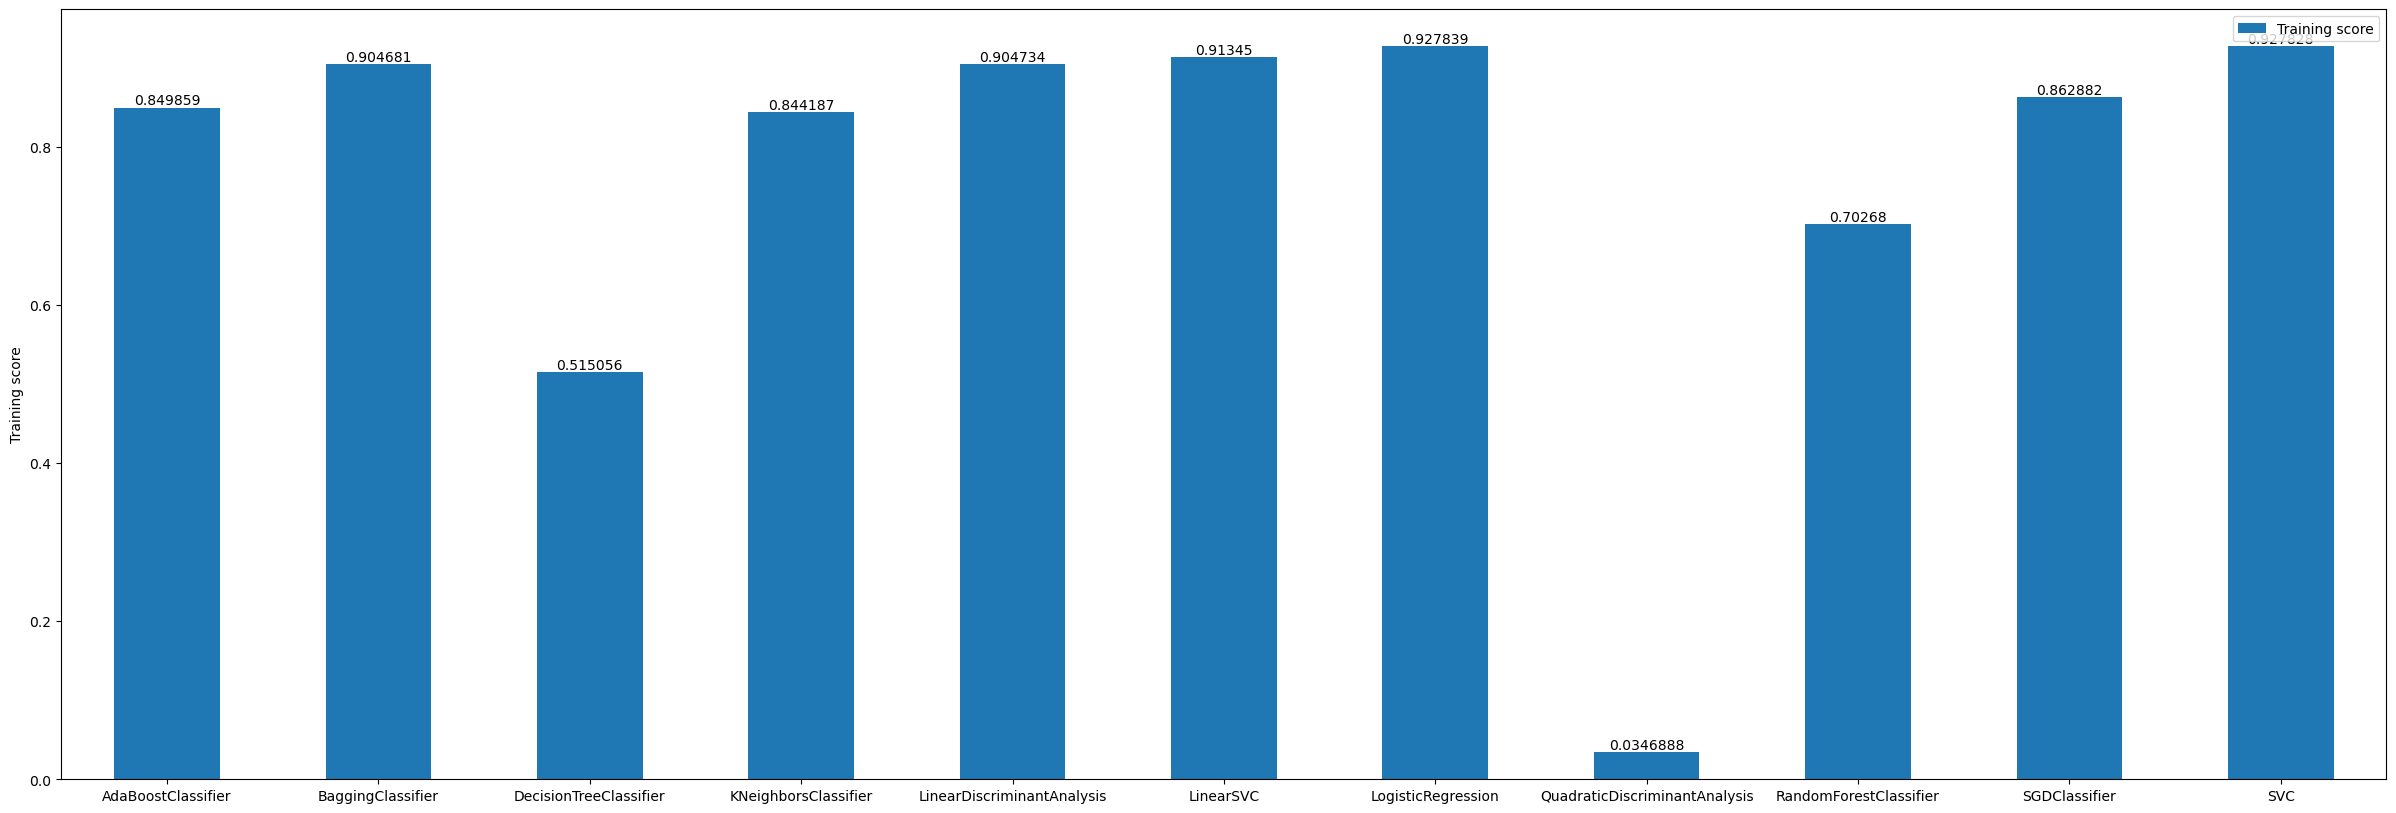

In [6]:
# change the config for a feature selection
for classifierDict in classifierList:
    classifierDict["feature"]["option"] = "selection"
    classifierDict["feature"]["config"] = {"estimator": Lasso()}

    if isinstance(classifierDict["fitStrategy"]["config"]["param_grid"], list):
        for L in classifierDict["fitStrategy"]["config"]["param_grid"]:
            del L["ftr__n_components"]
            L["ftr__estimator__alpha"] = [
                1.0,
                2.5,
                5.0,
            ]

    else:
        del classifierDict["fitStrategy"]["config"]["param_grid"]["ftr__n_components"]
        classifierDict["fitStrategy"]["config"]["param_grid"][
            "ftr__estimator__alpha"
        ] = [
            1.0,
            2.5,
            5.0,
        ]

clfSelection = hC.fitClassifiers(XTrain, YTrain, classifierList)  # fit

# Prediction results
## No feature trimming

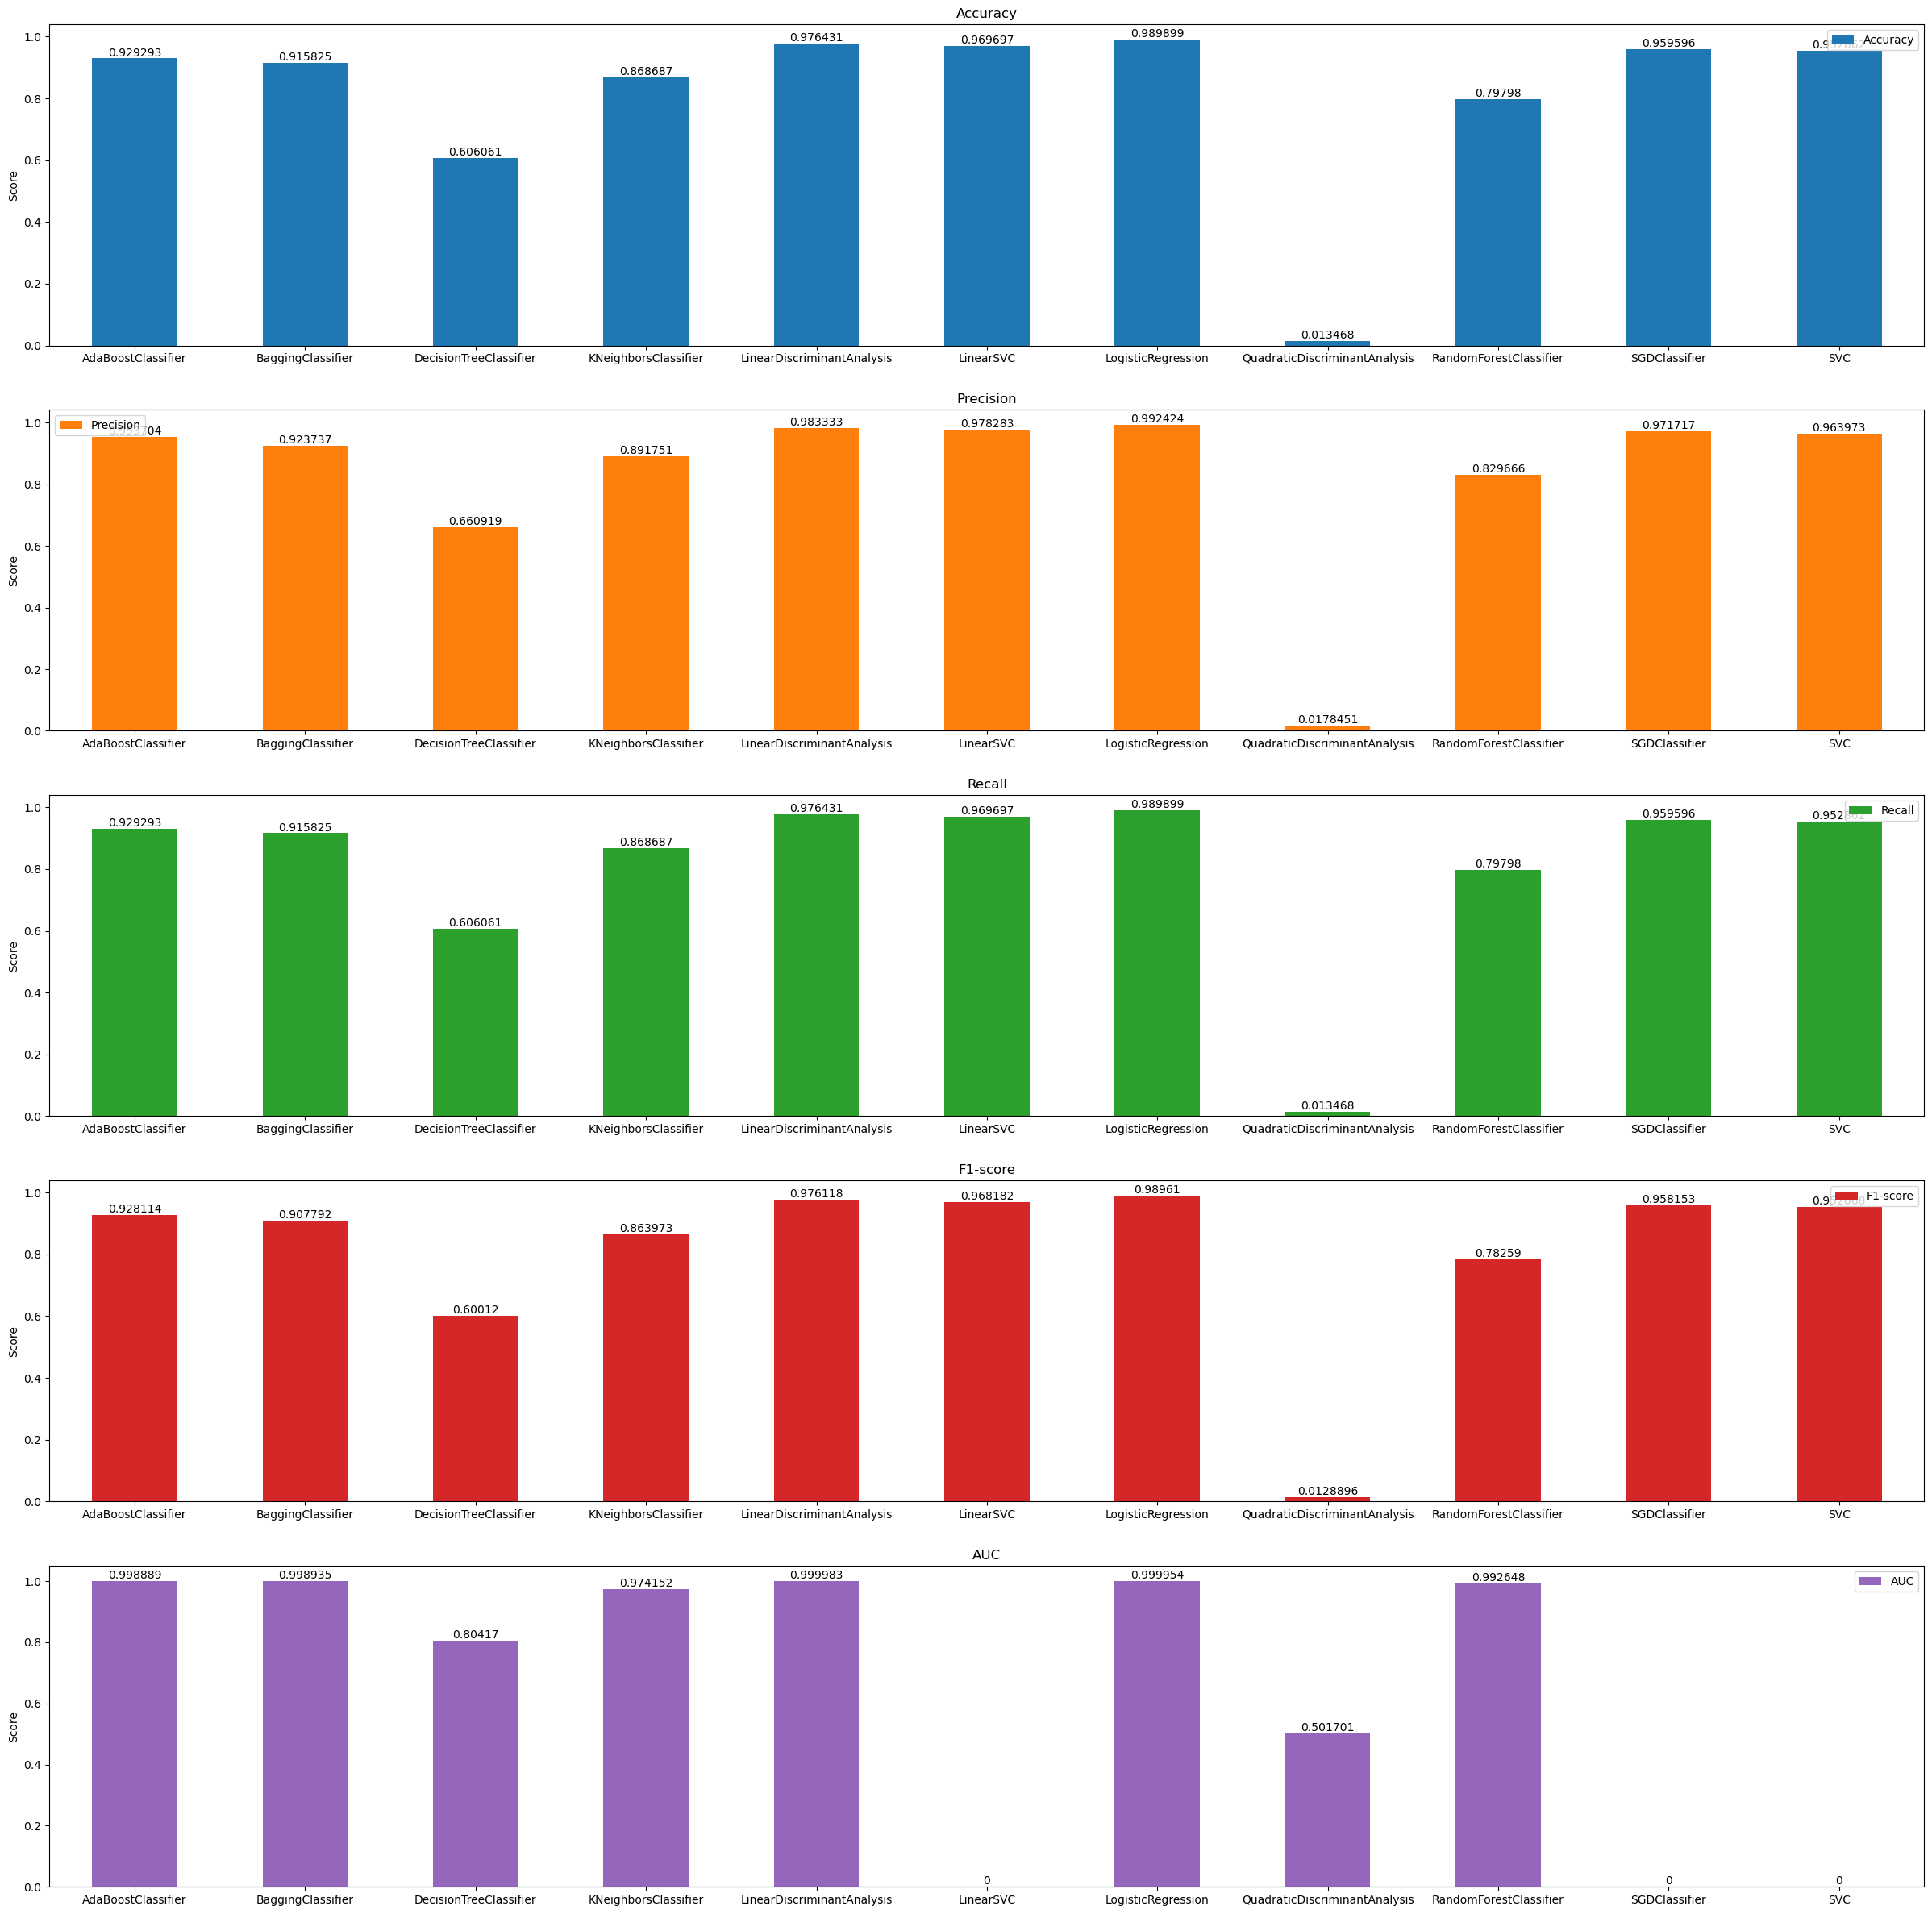

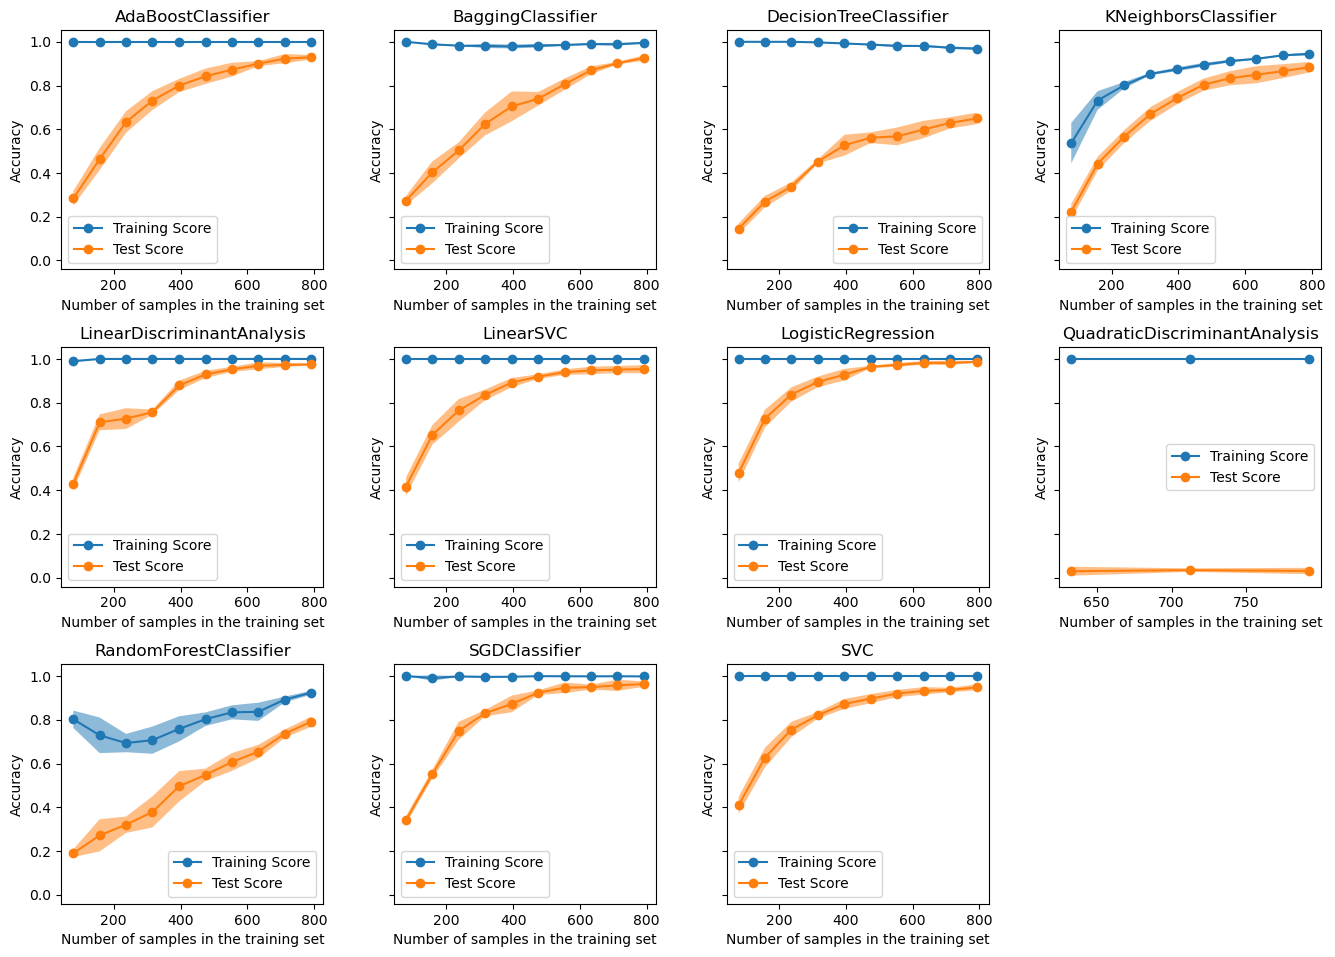

In [7]:
hM = handleMetrics()
hM.plotBarChart(XTest, YTest, clf)
hM.plotLearningCurve(df, "species", clf)

## Feature reduction (PCA)

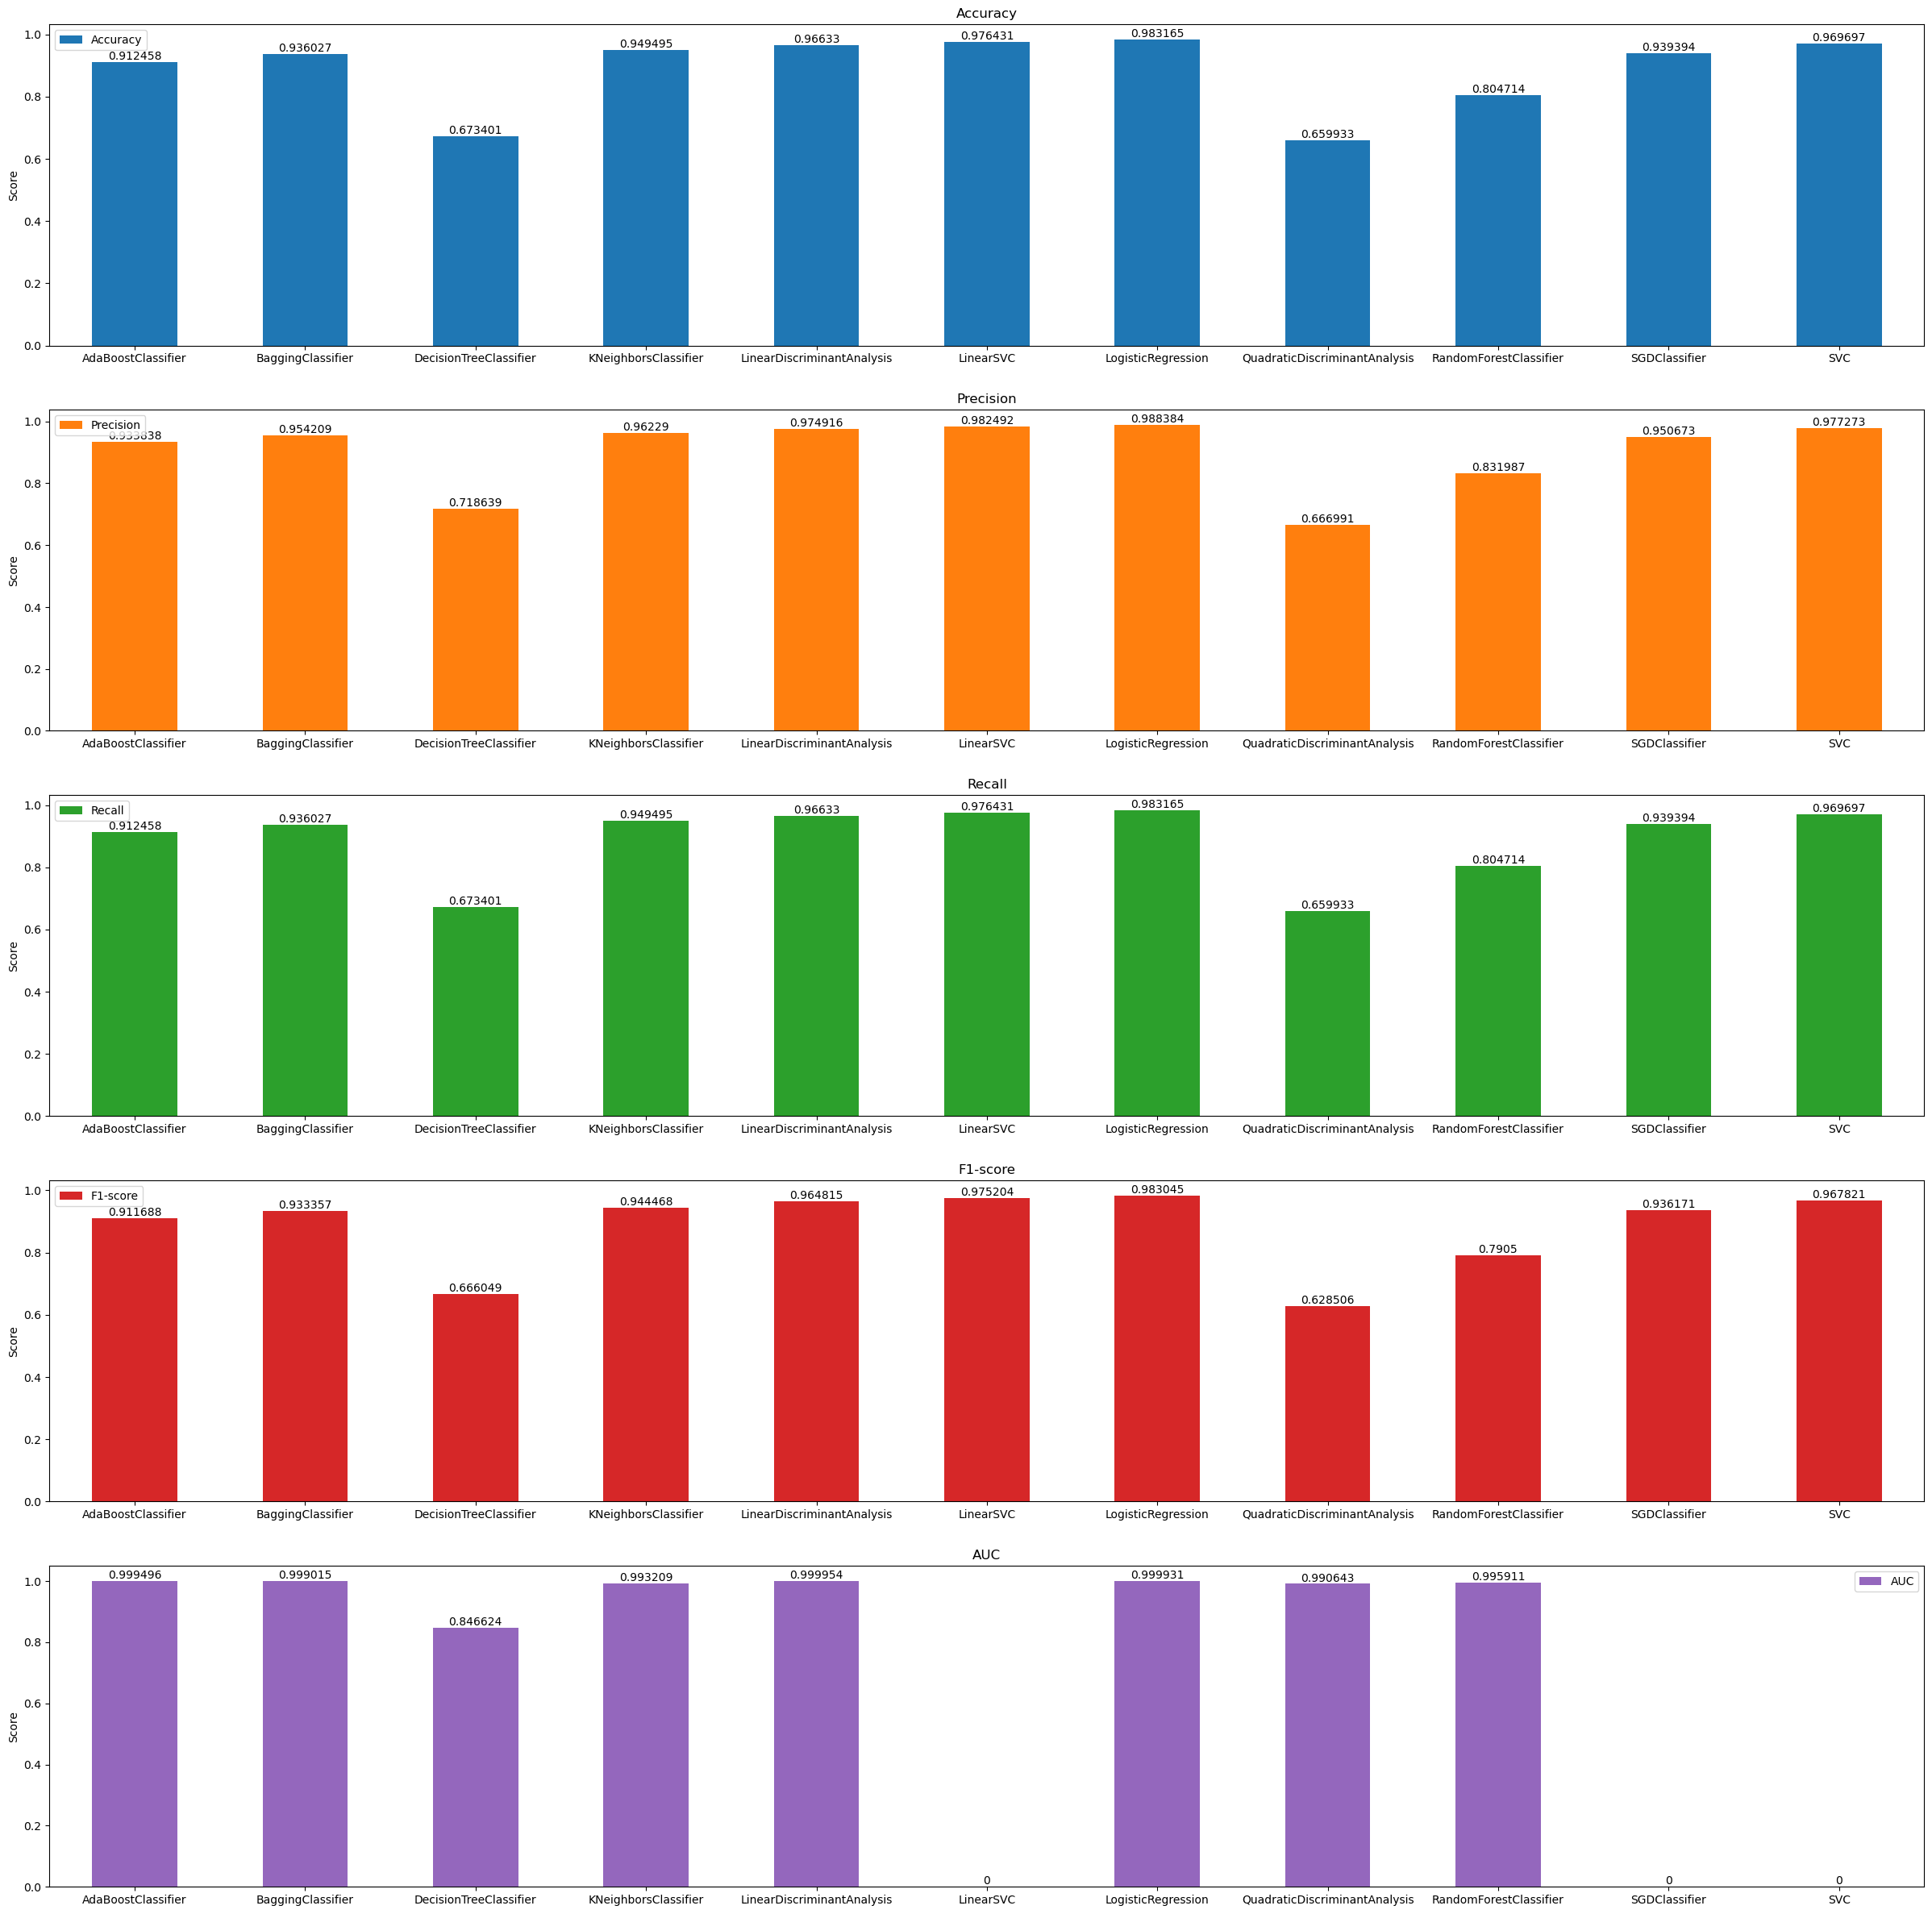

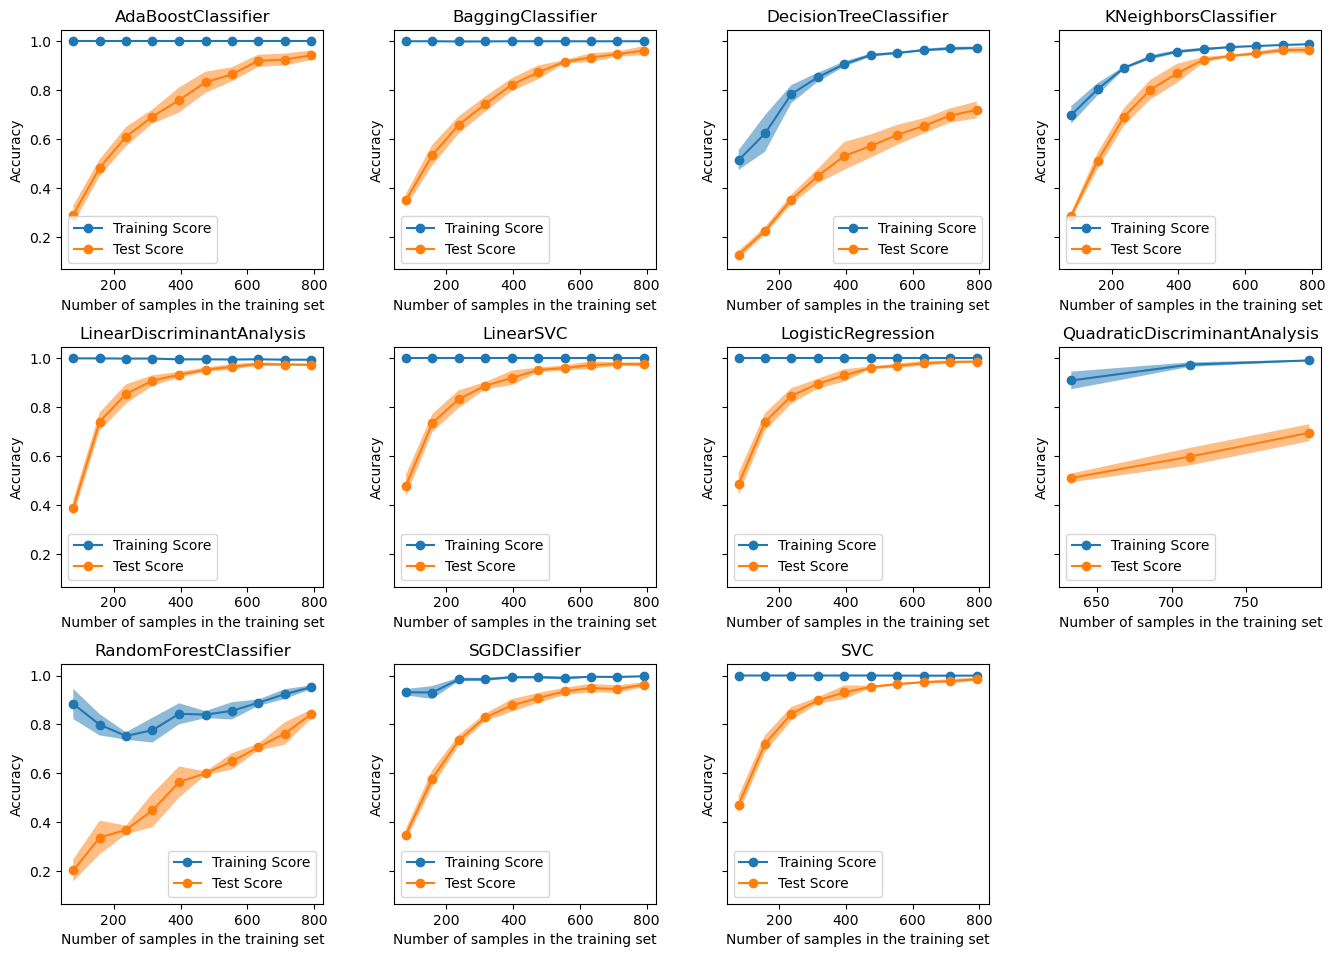

In [8]:
hM.plotBarChart(XTest, YTest, clfReduction)
hM.plotLearningCurve(df, "species", clfReduction)

## Feature selection (Lasso)

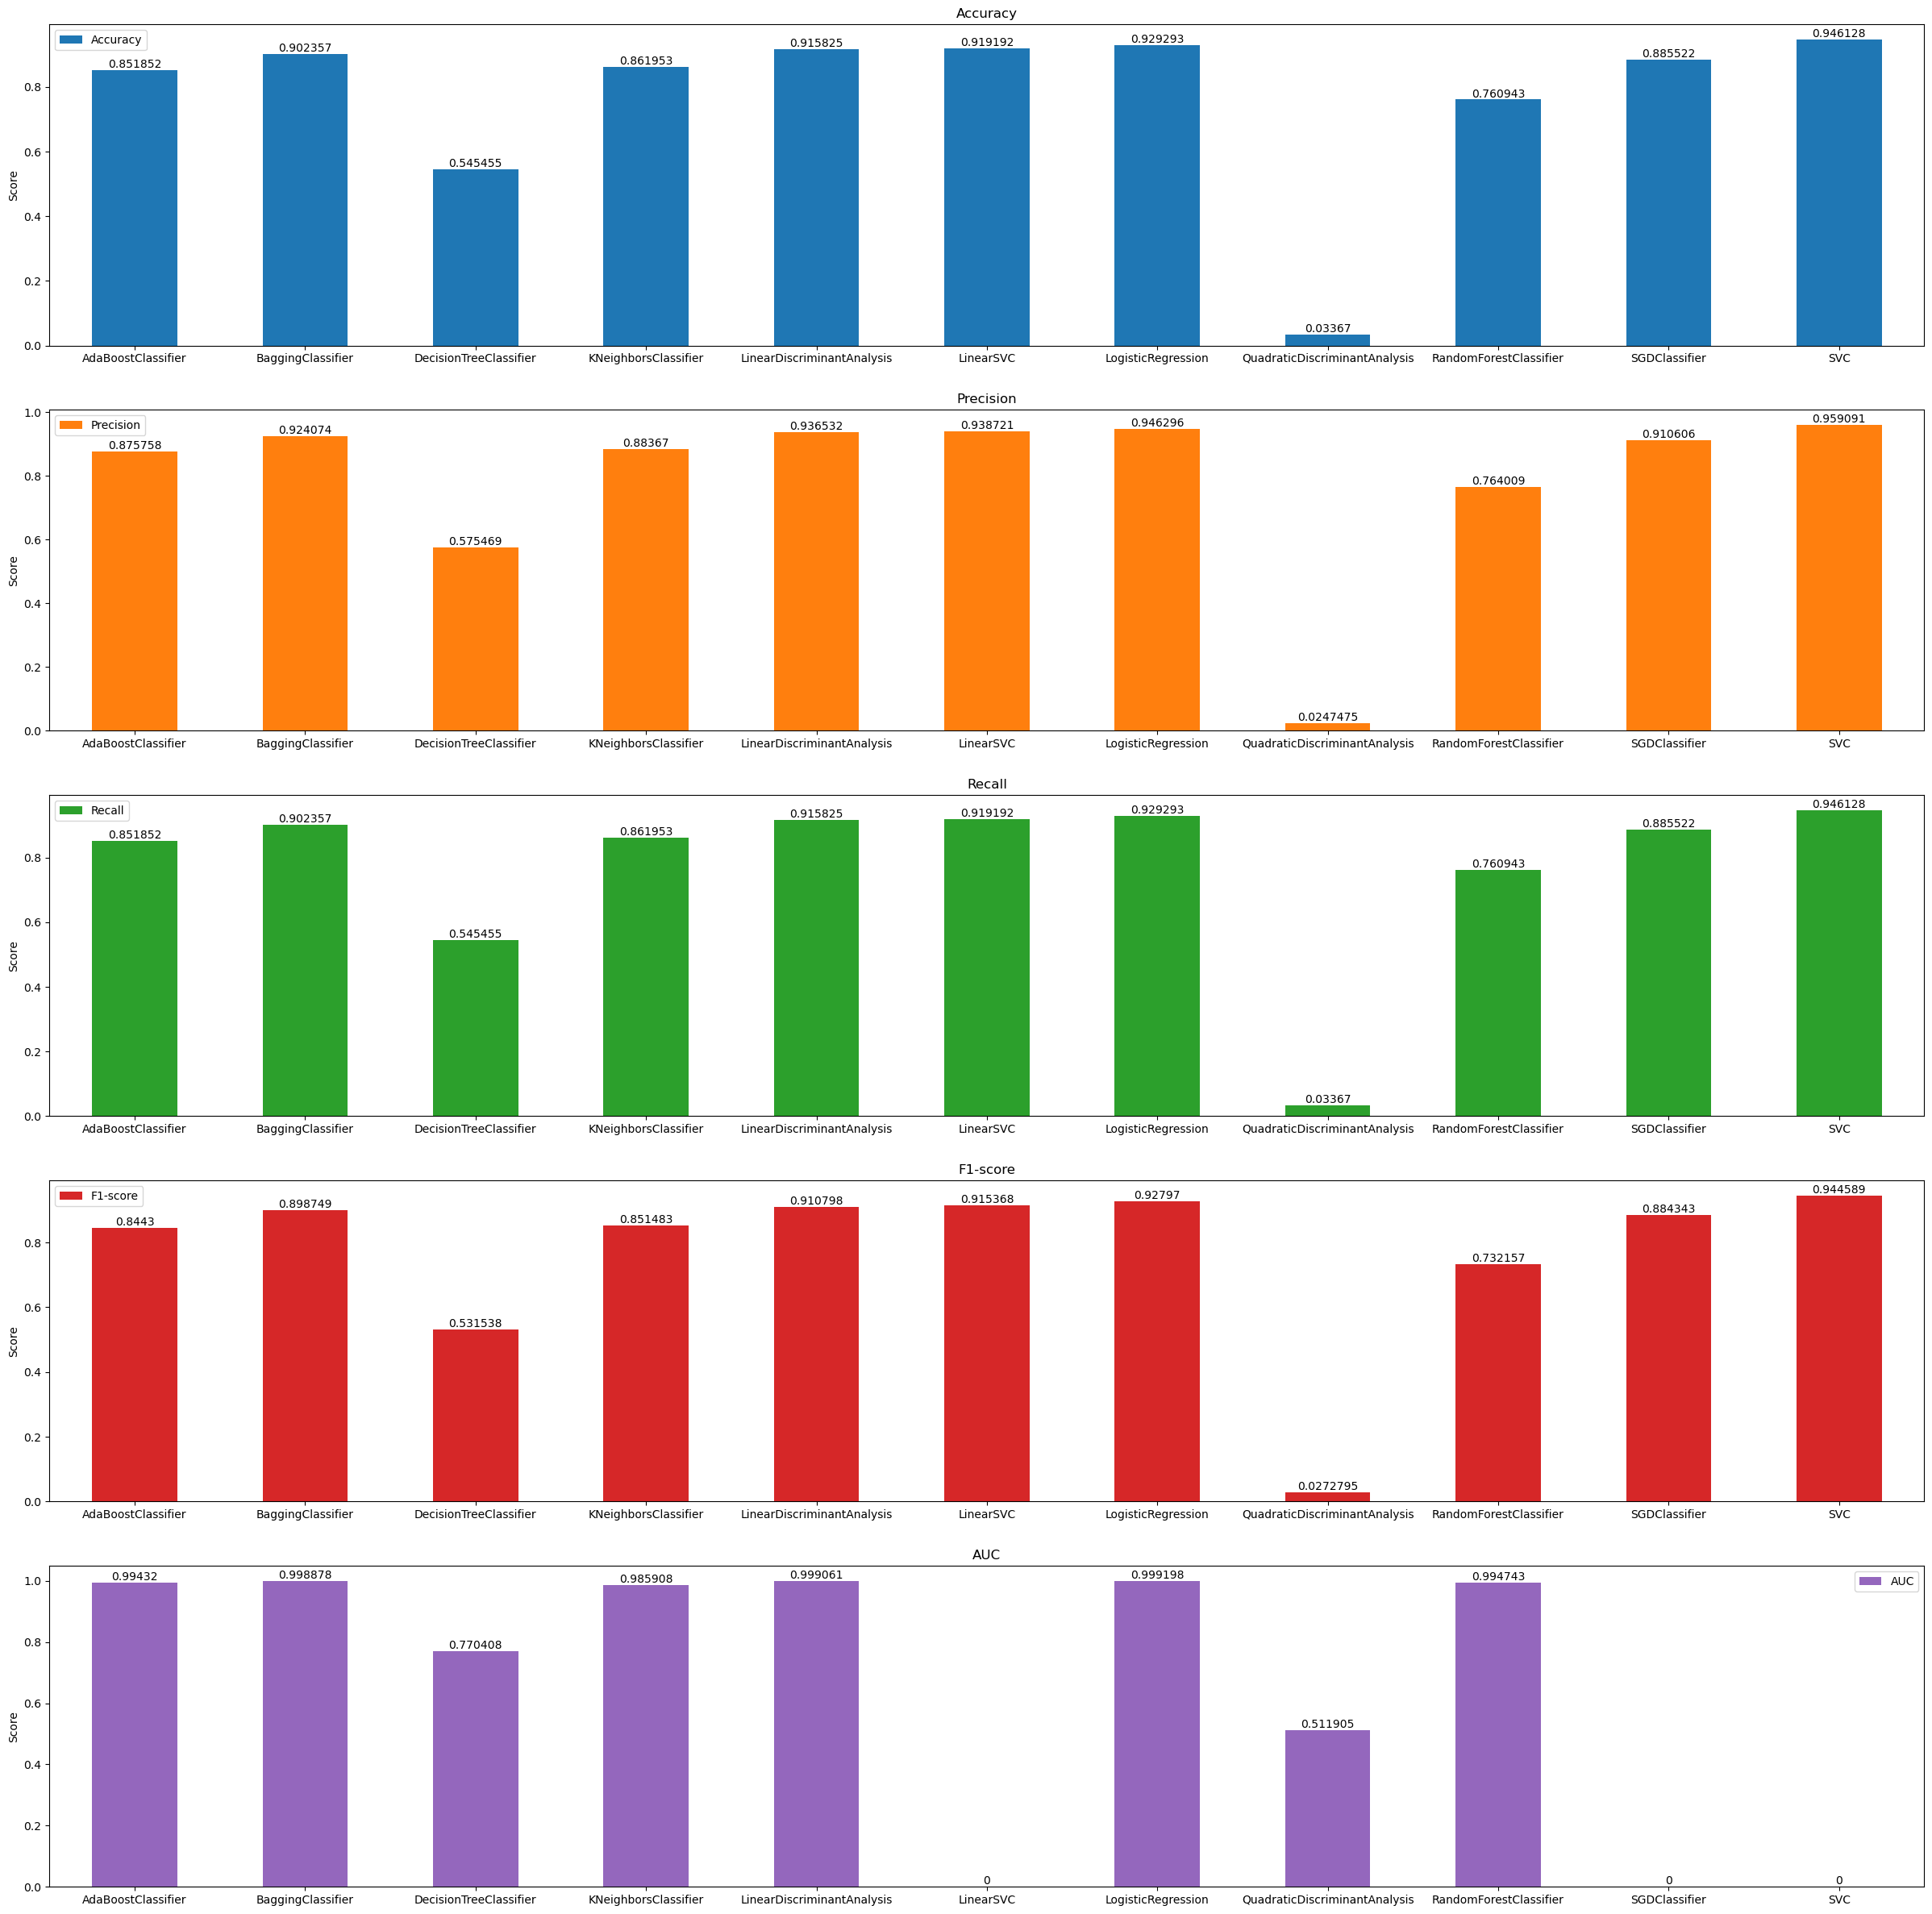

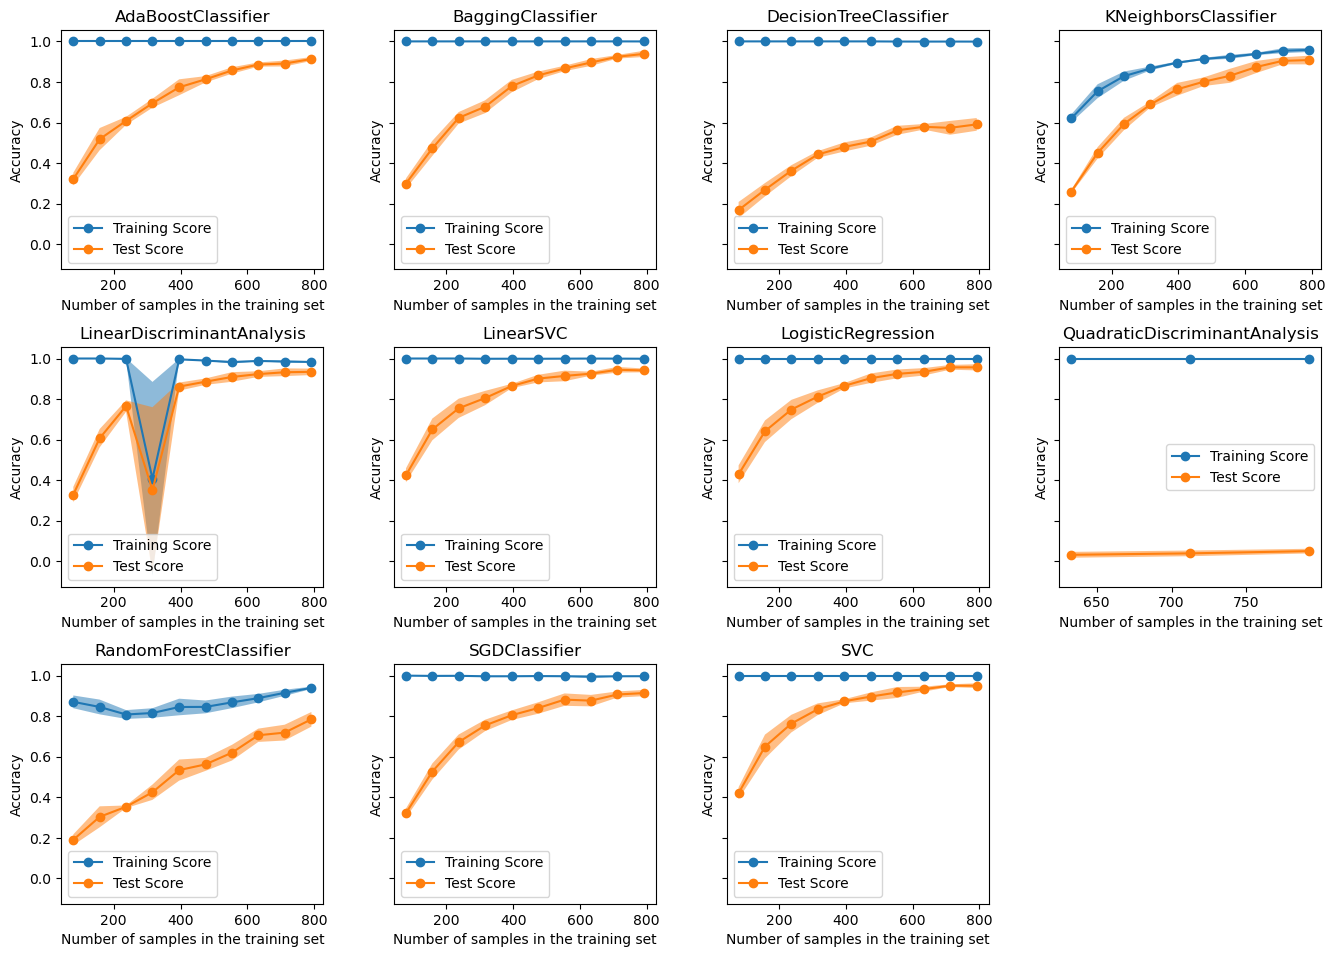

In [9]:
hM.plotBarChart(XTest, YTest, clfSelection)
hM.plotLearningCurve(df, "species", clfSelection)